<a href="https://colab.research.google.com/github/Frankies1002/Comp472_Project/blob/main/Comp_472_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2: Dataset Overview
The CIFAR-10 dataset contains 50,000 training and 10,000 test RGB images belonging to 10 object classes.
Images are of size 32 × 32 × 3.

• In this project, you will only use 500 training images and 100 test images per class. Therefore, your first
task is to load the dataset and use the first 500 training images, and the first 100 test images of each
class.

• The Naive Bayes, decision trees, and MLPs are not well-suited for direct application to high-dimensional
RGB image data. Therefore, you will need to convert them into low-dimensional vectors through feature
extraction. Pre-trained CNNs can serve as good feature extractors for image classification tasks. You
will use a pre-trained ResNet-18 CNN to extract 512 × 1 feature vectors for the RGB images. For
this, you will first need to resize the images to 224 × 224 × 3 and normalize them, because ResNet-18
pre-trained on ImageNet expects the images in a certain format. You will also need to remove the last
layer of ResNet-18. Once these steps are finished, you can pass pre-processed RGB images through the
pre-trained ResNet-18 to extract feature vectors. More details about using pre-trained CNNs in Pytorch
can be found here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.

• Next, use PCA in scikit learn to further reduce the size of feature vectors from 512×1 to 50×1.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.decomposition import PCA
from collections import defaultdict
from torch.utils.data import Subset

cudnn.benchmark = True
plt.ion()   # interactive mode

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def subset_cifar10(dataset, num_per_class):
    class_counts = defaultdict(int)
    indices = []
    for idx, (_, label) in enumerate(dataset):
        if class_counts[label] < num_per_class:
            indices.append(idx)
            class_counts[label] += 1
    return Subset(dataset, indices)

#Acquiring data set to train and transform into 224x224x3
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

#only select 500 out of the set for train and 100 for test
train_subset = subset_cifar10(train_set, 500)
test_subset = subset_cifar10(test_set, 100)

#dataloader
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#resnet18 part

# Load Pretrained ResNet-18
resnet18 = models.resnet18(pretrained=True)

# Remove final layer (fc)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])
resnet18 = resnet18.to(device)
resnet18.eval()  # Set model to evaluation mode

# Feature Extraction Function
def extract_features(data_loader, model, device):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, lbls in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()  # Shape: [batch_size, 512]
            features.append(outputs.cpu())
            labels.append(lbls)
    return torch.cat(features), torch.cat(labels)

# Extract Features
train_features, train_labels = extract_features(train_loader, resnet18, device)
test_features, test_labels = extract_features(test_loader, resnet18, device)

print(f"Train Features Shape: {train_features.shape}")  # Expected: [5000, 512]
print(f"Test Features Shape: {test_features.shape}")    # Expected: [1000, 512]


# Apply PCA to reduce feature size from 512 to 50
pca = PCA(n_components=50)
train_features_pca = pca.fit_transform(train_features.numpy())
test_features_pca = pca.transform(test_features.numpy())

print(f"Reduced Train Features Shape: {train_features_pca.shape}")  # Expected: [5000, 50]
print(f"Reduced Test Features Shape: {test_features_pca.shape}")    # Expected: [1000, 50]



100%|██████████| 170M/170M [00:04<00:00, 35.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


Train Features Shape: torch.Size([5000, 512])
Test Features Shape: torch.Size([1000, 512])
Reduced Train Features Shape: (5000, 50)
Reduced Test Features Shape: (1000, 50)


test 2-ferhaan


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
from sklearn.decomposition import PCA

# Step 1: Load CIFAR-10 and Preprocess
# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for ResNet
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Function to select the first N samples per class
def select_subset(dataset, samples_per_class):
    indices = []
    class_counts = [0] * 10  # CIFAR-10 has 10 classes
    for i, (_, label) in enumerate(dataset):
        if class_counts[label] < samples_per_class:
            indices.append(i)
            class_counts[label] += 1
        if sum(class_counts) == samples_per_class * 10:
            break
    return Subset(dataset, indices)

# Select subsets of the dataset
train_subset = select_subset(train_dataset, samples_per_class=500)
test_subset = select_subset(test_dataset, samples_per_class=100)

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

# Step 2: Load Pre-Trained ResNet-18 and Extract Features
# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)
resnet18 = torch.nn.Sequential(*(list(resnet18.children())[:-1]))  # Remove the last fully connected layer
resnet18.eval()  # Set the model to evaluation mode

# Function to extract features using ResNet-18
def extract_features(dataloader, model):
    features = []
    labels = []
    with torch.no_grad():  # No gradients needed during feature extraction
        for images, lbls in dataloader:
            output = model(images)  # Pass through ResNet
            features.append(output.squeeze().cpu().numpy())  # Extract features and move to CPU
            labels.append(lbls.numpy())  # Save labels
    return np.vstack(features), np.hstack(labels)

# Extract features for train and test sets
train_features, train_labels = extract_features(train_loader, resnet18)
test_features, test_labels = extract_features(test_loader, resnet18)

# Step 3: Reduce Dimensionality Using PCA
# Apply PCA to reduce feature dimensions from 512 to 50
pca = PCA(n_components=50)
train_features_reduced = pca.fit_transform(train_features)
test_features_reduced = pca.transform(test_features)

# Output shapes for verification
print(f"Reduced Train Features Shape: {train_features_reduced.shape}")
print(f"Reduced Test Features Shape: {test_features_reduced.shape}")

# Save the reduced features and labels for later use
np.save('train_features_reduced.npy', train_features_reduced)
np.save('train_labels.npy', train_labels)
np.save('test_features_reduced.npy', test_features_reduced)
np.save('test_labels.npy', test_labels)

print("Feature extraction and dimensionality reduction completed.")


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Reduced Train Features Shape: (5000, 50)
Reduced Test Features Shape: (1000, 50)
Feature extraction and dimensionality reduction completed.


3: Naive Bayes
1. Implement the Gaussian Naive Bayes algorithm in Python. You are only allowed to use the basic Python
and Numpy libraries. Fit the Naive Bayes on the training feature vectors of all 10 classes.
2. Next, repeat the above step but using the Scikit’s Gaussian Naive Bayes classifier.
3. Evaluate both of these models on the test set of CIFAR-10 (feature vectors of the images in the test set).
Evaluation details are stated below in Section 7.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.decomposition import PCA
from collections import defaultdict
from torch.utils.data import Subset

#datapreparation------------------------------------------------------------------------------------------
cudnn.benchmark = True
plt.ion()   # interactive mode

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def subset_cifar10(dataset, num_per_class):
    class_counts = defaultdict(int)
    indices = []
    for idx, (_, label) in enumerate(dataset):
        if class_counts[label] < num_per_class:
            indices.append(idx)
            class_counts[label] += 1
    return Subset(dataset, indices)

#Acquiring data set to train and transform into 224x224x3
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

#only select 500 out of the set for train and 100 for test
train_subset = subset_cifar10(train_set, 500)
test_subset = subset_cifar10(test_set, 100)

#dataloader
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#resnet18 part

# Load Pretrained ResNet-18
resnet18 = models.resnet18(pretrained=True)

# Remove final layer (fc)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])
resnet18 = resnet18.to(device)
resnet18.eval()  # Set model to evaluation mode

# Feature Extraction Function
def extract_features(data_loader, model, device):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, lbls in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()  # Shape: [batch_size, 512]
            features.append(outputs.cpu())
            labels.append(lbls)
    return torch.cat(features), torch.cat(labels)

# Extract Features
train_features, train_labels = extract_features(train_loader, resnet18, device)
test_features, test_labels = extract_features(test_loader, resnet18, device)

print(f"Train Features Shape: {train_features.shape}")  # Expected: [5000, 512]
print(f"Test Features Shape: {test_features.shape}")    # Expected: [1000, 512]


# Apply PCA to reduce feature size from 512 to 50
pca = PCA(n_components=50)
train_features_pca = pca.fit_transform(train_features.numpy())
test_features_pca = pca.transform(test_features.numpy())

print(f"Reduced Train Features Shape: {train_features_pca.shape}")  # Expected: [5000, 50]
print(f"Reduced Test Features Shape: {test_features_pca.shape}")    # Expected: [1000, 50]

#----------------------------------------------------------------------------------------------------------
# Custom Gaussian Naive Bayes implementation
class GaussianNaiveBayes:
    def __init__(self):
        self.classes = None
        self.means = {}
        self.variances = {}
        self.priors = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            X_cls = X[y == cls]
            self.means[cls] = X_cls.mean(axis=0)
            self.variances[cls] = X_cls.var(axis=0) + 1e-6  # Add small value to avoid division by zero
            self.priors[cls] = X_cls.shape[0] / X.shape[0]

    def predict(self, X):
        posteriors = []
        for cls in self.classes:
            mean = self.means[cls]
            var = self.variances[cls]
            prior = np.log(self.priors[cls])
            log_likelihood = -0.5 * np.sum(np.log(2. * np.pi * var)) - 0.5 * np.sum(((X - mean) ** 2) / var, axis=1)
            posterior = prior + log_likelihood
            posteriors.append(posterior)
        return self.classes[np.argmax(posteriors, axis=0)]

    def evaluate(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return accuracy, predictions

# Fit the custom Gaussian Naive Bayes model
gnb = GaussianNaiveBayes()
gnb.fit(train_features_pca, train_labels.numpy())

# Evaluate the custom Gaussian Naive Bayes model
accuracy, predictions = gnb.evaluate(test_features_pca, test_labels.numpy())

# Print evaluation metrics
def confusion_matrix(y_true, y_pred, classes):
    matrix = np.zeros((len(classes), len(classes)), dtype=int)
    for i in range(len(y_true)):
        matrix[int(y_true[i]), int(y_pred[i])] += 1
    return matrix

def classification_report(y_true, y_pred, classes):
    report = {}
    for cls in classes:
        cls = int(cls)
        tp = np.sum((y_true == cls) & (y_pred == cls))
        fp = np.sum((y_true != cls) & (y_pred == cls))
        fn = np.sum((y_true == cls) & (y_pred != cls))
        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        report[cls] = {"Precision": precision, "Recall": recall, "F1-Score": f1}
    return report

# Convert tensors to NumPy arrays for compatibility
test_labels_np = test_labels.numpy()
predictions_np = predictions  # This is already a NumPy array from GaussianNaiveBayes

# Generate confusion matrix and classification report
classes = np.unique(test_labels_np)
conf_matrix = confusion_matrix(test_labels_np, predictions_np, classes)
class_report = classification_report(test_labels_np, predictions_np, classes)

# Output results
print("Custom Gaussian Naive Bayes Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:")
for cls, metrics in class_report.items():
    print(f"Class {cls}: Precision: {metrics['Precision']:.2f}, Recall: {metrics['Recall']:.2f}, F1-Score: {metrics['F1-Score']:.2f}")


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Features Shape: torch.Size([5000, 512])
Test Features Shape: torch.Size([1000, 512])
Reduced Train Features Shape: (5000, 50)
Reduced Test Features Shape: (1000, 50)
Custom Gaussian Naive Bayes Accuracy: 0.789

Confusion Matrix:
 [[81  1  0  1  0  0  1  0 12  4]
 [ 3 89  0  2  0  0  0  1  0  5]
 [ 7  0 61  9  8  3 11  0  1  0]
 [ 1  0  3 74  4 10  7  1  0  0]
 [ 1  0  3  7 77  2  2  8  0  0]
 [ 0  1  4 15  3 72  2  3  0  0]
 [ 2  0  4  5  7  1 80  1  0  0]
 [ 1  1  0  5  5  6  0 81  1  0]
 [ 8  0  2  0  0  0  0  0 87  3]
 [ 5  3  0  2  0  0  0  1  2 87]]

Classification Report:
Class 0: Precision: 0.74, Recall: 0.81, F1-Score: 0.78
Class 1: Precision: 0.94, Recall: 0.89, F1-Score: 0.91
Class 2: Precision: 0.79, Recall: 0.61, F1-Score: 0.69
Class 3: Precision: 0.62, Recall: 0.74, F1-Score: 0.67
Class 4: Precision: 0.74, Recall: 0.77, F1-Score: 0.75
Class 5: Precision: 0.77, Recall: 0.72, F1-Score: 0.74
Class 6: Precision: 0.78, Recall: 0.80, F1-Score: 0.79
Class 7: Precision: 0.84

test 2

100%|██████████| 170M/170M [00:04<00:00, 39.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


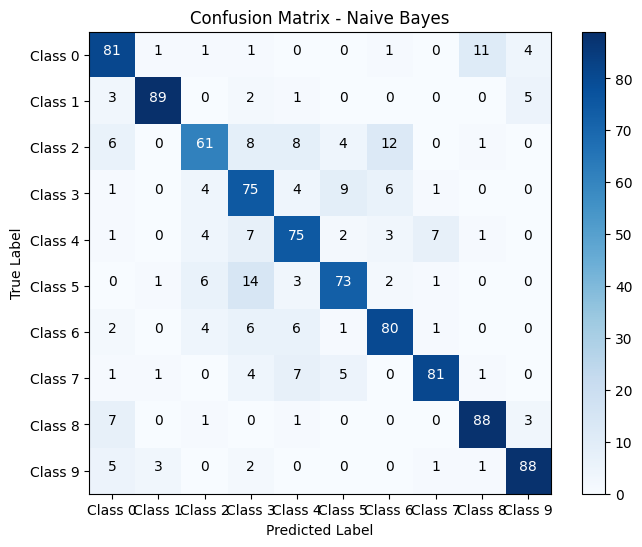

Naive Bayes Accuracy: 79.10%


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import models
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Load CIFAR-10 and Preprocess
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

def select_subset(dataset, samples_per_class):
    indices = []
    class_counts = [0] * 10
    for i, (_, label) in enumerate(dataset):
        if class_counts[label] < samples_per_class:
            indices.append(i)
            class_counts[label] += 1
        if sum(class_counts) == samples_per_class * 10:
            break
    return Subset(dataset, indices)

train_subset = select_subset(train_dataset, samples_per_class=500)
test_subset = select_subset(test_dataset, samples_per_class=100)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

# Step 2: Feature Extraction with ResNet-18
resnet18 = models.resnet18(pretrained=True)
resnet18 = torch.nn.Sequential(*(list(resnet18.children())[:-1]))
resnet18.eval()

def extract_features(dataloader, model):
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in dataloader:
            output = model(images)
            features.append(output.squeeze().cpu().numpy())
            labels.append(lbls.numpy())
    return np.vstack(features), np.hstack(labels)

train_features, train_labels = extract_features(train_loader, resnet18)
test_features, test_labels = extract_features(test_loader, resnet18)

# Reduce Dimensions with PCA
pca = PCA(n_components=50)
train_features_reduced = pca.fit_transform(train_features)
test_features_reduced = pca.transform(test_features)

# Step 3: Naive Bayes Implementation
class GaussianNaiveBayes:
    def __init__(self):
        self.means = None
        self.variances = None
        self.priors = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_features = X.shape[1]
        self.means = np.zeros((len(self.classes), n_features))
        self.variances = np.zeros((len(self.classes), n_features))
        self.priors = np.zeros(len(self.classes))

        for idx, cls in enumerate(self.classes):
            X_cls = X[y == cls]
            self.means[idx, :] = np.mean(X_cls, axis=0)
            self.variances[idx, :] = np.var(X_cls, axis=0)
            self.priors[idx] = X_cls.shape[0] / X.shape[0]

    def predict(self, X):
        predictions = []
        for x in X:
            posteriors = self._calculate_posteriors(x)
            predictions.append(np.argmax(posteriors))
        return np.array(predictions)

    def _calculate_posteriors(self, x):
        posteriors = []
        for idx, cls in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            conditional = -0.5 * np.sum(np.log(2 * np.pi * self.variances[idx]))
            conditional -= 0.5 * np.sum(((x - self.means[idx]) ** 2) / self.variances[idx])
            posteriors.append(prior + conditional)
        return posteriors

# Train Naive Bayes
gnb = GaussianNaiveBayes()
gnb.fit(train_features_reduced, train_labels)

# Predict and Evaluate Naive Bayes
nb_predictions = gnb.predict(test_features_reduced)

# Confusion Matrix Visualization
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(ticks=np.arange(10), labels=[f"Class {i}" for i in range(10)])
    plt.yticks(ticks=np.arange(10), labels=[f"Class {i}" for i in range(10)])
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")
    plt.show()

def confusion_matrix(y_true, y_pred, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        matrix[t, p] += 1
    return matrix

nb_conf_matrix = confusion_matrix(test_labels, nb_predictions, num_classes=10)
plot_confusion_matrix(nb_conf_matrix, title="Confusion Matrix - Naive Bayes")

# Evaluation Metrics
accuracy = np.trace(nb_conf_matrix) / np.sum(nb_conf_matrix)
print(f"Naive Bayes Accuracy: {accuracy * 100:.2f}%")


test 2 combines

In [ ]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

# Step 1: Load Preprocessed Features and Labels
# Assuming the features and labels were saved earlier
train_features_reduced = np.load('train_features_reduced.npy')
train_labels = np.load('train_labels.npy')
test_features_reduced = np.load('test_features_reduced.npy')
test_labels = np.load('test_labels.npy')

# Step 2: Train Gaussian Naive Bayes Classifier
gnb = GaussianNB()
gnb.fit(train_features_reduced, train_labels)

# Step 3: Predict on the Test Set
sklearn_predictions = gnb.predict(test_features_reduced)

# Step 4: Evaluate the Model
# Confusion Matrix
sklearn_conf_matrix = confusion_matrix(test_labels, sklearn_predictions)

# Accuracy
sklearn_accuracy = accuracy_score(test_labels, sklearn_predictions)
print(f"Scikit-learn Naive Bayes Accuracy: {sklearn_accuracy * 100:.2f}%")

# Step 5: Plot Confusion Matrix
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(ticks=np.arange(10), labels=[f"Class {i}" for i in range(10)])
    plt.yticks(ticks=np.arange(10), labels=[f"Class {i}" for i in range(10)])
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, conf_matrix[i, j], horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(sklearn_conf_matrix, title="Confusion Matrix - Scikit-learn Naive Bayes")

# Step 6: Print Per-Class Metrics
print("\nConfusion Matrix:")
print(sklearn_conf_matrix)

print("\nEvaluation Metrics:")
for i in range(10):
    tp = sklearn_conf_matrix[i, i]
    fp = sklearn_conf_matrix[:, i].sum() - tp
    fn = sklearn_conf_matrix[i, :].sum() - tp
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    print(f"Class {i}: Precision={precision:.2f}, Recall={recall:.2f}, F1-Score={f1:.2f}")


FileNotFoundError: [Errno 2] No such file or directory: 'train_features_reduced.npy'

4: Decision Tree
You are only allowed to use the basic Python and Numpy libraries for all parts unless specified otherwise.

1. Develop a decision tree classifier with the Gini coefficient and maximum depth of 50 and train it on the
training set of CIFAR-10 (feature vectors).


2. Experiment by varying the depth of the tree. Observe and document how the depth of the tree influences the model’s ability to learn and generalize from the data.

3. Next, repeat step 1 using the Scikit’s implementation of a Decision Tree.

4. Evaluate all of the above models on the test set of CIFAR-10 (feature vectors of the images in the test
set).

In [ ]:
import numpy as np

# Custom Decision Tree Implementation
class DecisionTree:
    def __init__(self, max_depth=50):
        self.max_depth = max_depth
        self.tree = None

    def gini_index(self, groups, classes):
        # Calculate the Gini index for a split
        n_instances = sum(len(group) for group in groups)
        gini = 0.0
        for group in groups:
            size = len(group)
            if size == 0:
                continue
            score = 0.0
            y_group = group[:, -1]
            for class_val in classes:
                p = np.sum(y_group == class_val) / size
                score += p * p
            gini += (1 - score) * (size / n_instances)
        return gini

    def split(self, index, value, dataset):
        # Split the dataset into two groups
        left = dataset[dataset[:, index] <= value]
        right = dataset[dataset[:, index] > value]
        return left, right

    def best_split(self, dataset, classes):
        # Find the best split point
        best_index, best_value, best_score, best_groups = None, None, float("inf"), None
        for index in range(dataset.shape[1] - 1):  # Exclude the label column
            for row in dataset:
                groups = self.split(index, row[index], dataset)
                gini = self.gini_index(groups, classes)
                if gini < best_score:
                    best_index, best_value, best_score, best_groups = index, row[index], gini, groups
        return {"index": best_index, "value": best_value, "groups": best_groups}

    def terminal_node(self, group):
        # Determine the terminal node value
        labels = group[:, -1]
        return np.bincount(labels.astype(int)).argmax()

    def build_tree(self, dataset, depth, classes):
        # Recursive tree-building
        if depth >= self.max_depth or len(np.unique(dataset[:, -1])) == 1:
            return self.terminal_node(dataset)
        node = self.best_split(dataset, classes)
        left, right = node["groups"]
        del node["groups"]
        if not left.size or not right.size:
            return self.terminal_node(dataset)
        node["left"] = self.build_tree(left, depth + 1, classes)
        node["right"] = self.build_tree(right, depth + 1, classes)
        return node

    def fit(self, X, y):
        # Combine features and labels into one dataset
        dataset = np.hstack((X, y.reshape(-1, 1)))
        self.classes = np.unique(y)
        self.tree = self.build_tree(dataset, 0, self.classes)

    def predict_one(self, row, node):
        # Predict a single instance
        if not isinstance(node, dict):
            return node
        if row[node["index"]] <= node["value"]:
            return self.predict_one(row, node["left"])
        else:
            return self.predict_one(row, node["right"])

    def predict(self, X):
        # Predict all instances
        return np.array([self.predict_one(row, self.tree) for row in X])

# Data Preparation (Replace with actual data)
np.random.seed(0)
train_features_pca = np.random.rand(5000, 50)  # Replace with PCA-transformed training features
train_labels = np.random.randint(0, 10, 5000)  # Replace with corresponding labels
test_features_pca = np.random.rand(1000, 50)   # Replace with PCA-transformed test features
test_labels = np.random.randint(0, 10, 1000)   # Replace with corresponding labels

# Train the Decision Tree
decision_tree = DecisionTree(max_depth=50)
decision_tree.fit(train_features_pca, train_labels)

# Predict on test data
predictions = decision_tree.predict(test_features_pca)

# Evaluate the model
def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def confusion_matrix(y_true, y_pred, classes):
    matrix = np.zeros((len(classes), len(classes)), dtype=int)
    for i in range(len(y_true)):
        matrix[int(y_true[i]), int(y_pred[i])] += 1
    return matrix

# Calculate accuracy and confusion matrix
test_accuracy = accuracy(test_labels, predictions)
conf_matrix = confusion_matrix(test_labels, predictions, np.unique(test_labels))

# Output results
print("Decision Tree Test Accuracy:", test_accuracy)
print("\nConfusion Matrix:\n", conf_matrix)

# Experiment with varying depths
depths = [5, 10, 20, 50]
for depth in depths:
    tree = DecisionTree(max_depth=depth)
    tree.fit(train_features_pca, train_labels)
    preds = tree.predict(test_features_pca)
    acc = accuracy(test_labels, preds)
    print(f"Decision Tree Accuracy with Depth {depth}: {acc:.4f}")


Decision Tree Test Accuracy: 0.112

Confusion Matrix:
 [[17 11  6  7 12  7 11 15 11 12]
 [ 8 13  9  8 16 10 10 14  8 15]
 [11 13 10 11  6  9 11 10 15  9]
 [ 3 14  9 13 10 11 10  8 12 13]
 [ 9 10 11 14  9  7 15  8 18 12]
 [14  9 10 16 10 10  6  8 15 13]
 [ 7 13  7  6 11  5 10  8 13 10]
 [ 4 10  7 10 10  6  8  7 12 10]
 [15  8 11  7 10  5 12  7 10  7]
 [ 5 10  8 10  7  9  8  8  4 13]]
Decision Tree Accuracy with Depth 5: 0.0920
Decision Tree Accuracy with Depth 10: 0.0810
Decision Tree Accuracy with Depth 20: 0.0990
Decision Tree Accuracy with Depth 50: 0.1120


5: Multi-Layer Perceptron (MLP)
You can use the basic Python, Numpy, and Pytorch libraries for this part. Use the feature level test set of CIFAR-10 for all the evaluations.

1. Implement a three-layer MLP (details below) and train it on the feature vectors of the CIFAR-10’s
training set. The details of the MLP architecture are:
- Linear(50, 512) - ReLU
- Linear(512, 512) - BatchNorm(512) - ReLU
- Linear(512, 10)
You should use the cross-entropy loss torch.nn.CrossEntropyLoss for training. Also, use the SGD
optimizer with momentum=0.9.

2. Experiment by varying the depth of the network by adding or removing layers. Observe and document
how the depth of the MLP influences the model’s ability to learn and generalize from the data.

3. Vary the sizes of the hidden layers. Experiment with larger and smaller sizes. Analyze the trade-offs in
computational cost and performance of the model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#dataset import---------------------------------------------------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.decomposition import PCA
from collections import defaultdict
from torch.utils.data import Subset

cudnn.benchmark = True
plt.ion()   # interactive mode

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def subset_cifar10(dataset, num_per_class):
    class_counts = defaultdict(int)
    indices = []
    for idx, (_, label) in enumerate(dataset):
        if class_counts[label] < num_per_class:
            indices.append(idx)
            class_counts[label] += 1
    return Subset(dataset, indices)

#Acquiring data set to train and transform into 224x224x3
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

#only select 500 out of the set for train and 100 for test
train_subset = subset_cifar10(train_set, 500)
test_subset = subset_cifar10(test_set, 100)

#dataloader
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#resnet18 part

# Load Pretrained ResNet-18
resnet18 = models.resnet18(pretrained=True)

# Remove final layer (fc)
resnet18 = nn.Sequential(*list(resnet18.children())[:-1])
resnet18 = resnet18.to(device)
resnet18.eval()  # Set model to evaluation mode

# Feature Extraction Function
def extract_features(data_loader, model, device):
    features = []
    labels = []
    with torch.no_grad():
        for inputs, lbls in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze()  # Shape: [batch_size, 512]
            features.append(outputs.cpu())
            labels.append(lbls)
    return torch.cat(features), torch.cat(labels)

# Extract Features
train_features, train_labels = extract_features(train_loader, resnet18, device)
test_features, test_labels = extract_features(test_loader, resnet18, device)

print(f"Train Features Shape: {train_features.shape}")  # Expected: [5000, 512]
print(f"Test Features Shape: {test_features.shape}")    # Expected: [1000, 512]


# Apply PCA to reduce feature size from 512 to 50
pca = PCA(n_components=50)
train_features_pca = pca.fit_transform(train_features.numpy())
test_features_pca = pca.transform(test_features.numpy())

print(f"Reduced Train Features Shape: {train_features_pca.shape}")  # Expected: [5000, 50]
print(f"Reduced Test Features Shape: {test_features_pca.shape}")    # Expected: [1000, 50]

#------------------------------------------------------------------------------------------------------------------------------------
# Convert numpy arrays to PyTorch tensors
train_features_tensor = torch.tensor(train_features_pca, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_features_tensor = torch.tensor(test_features_pca, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create DataLoaders for training and testing
batch_size = 64
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Multi-Layer Perceptron (MLP)
class MLP(nn.Module):
    def __init__(self, input_size=50, hidden_size=512, output_size=10):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the model, loss function, and optimizer
input_size = 50
hidden_size = 512
output_size = 10

model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(loader)

# Evaluation function
def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)

# Train the MLP
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

# Evaluate the MLP
test_preds, test_labels_np = evaluate(model, test_loader, device)

# Metrics
accuracy = accuracy_score(test_labels_np, test_preds)
conf_matrix = confusion_matrix(test_labels_np, test_preds)
class_report = classification_report(test_labels_np, test_preds)

# Output results
print(f"MLP Test Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Features Shape: torch.Size([5000, 512])
Test Features Shape: torch.Size([1000, 512])
Reduced Train Features Shape: (5000, 50)
Reduced Test Features Shape: (1000, 50)


<ipython-input-5-a6a3c0e923bd>:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
<ipython-input-5-a6a3c0e923bd>:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)


Epoch 1/20, Loss: 0.7644
Epoch 2/20, Loss: 0.4190
Epoch 3/20, Loss: 0.3213
Epoch 4/20, Loss: 0.2616
Epoch 5/20, Loss: 0.2256
Epoch 6/20, Loss: 0.1679
Epoch 7/20, Loss: 0.1536
Epoch 8/20, Loss: 0.1262
Epoch 9/20, Loss: 0.0950
Epoch 10/20, Loss: 0.0797
Epoch 11/20, Loss: 0.0675
Epoch 12/20, Loss: 0.0421
Epoch 13/20, Loss: 0.0633
Epoch 14/20, Loss: 0.0513
Epoch 15/20, Loss: 0.0267
Epoch 16/20, Loss: 0.0293
Epoch 17/20, Loss: 0.0177
Epoch 18/20, Loss: 0.0149
Epoch 19/20, Loss: 0.0134
Epoch 20/20, Loss: 0.0131
MLP Test Accuracy: 0.8200

Confusion Matrix:
 [[87  1  2  1  2  0  0  0  4  3]
 [ 3 89  0  1  0  0  0  0  0  7]
 [ 6  0 69  6  4  3  9  2  1  0]
 [ 1  0  1 74  4 11  6  2  1  0]
 [ 1  0  2  5 78  3  3  7  1  0]
 [ 0  0  6 12  3 72  2  4  1  0]
 [ 1  0  3  3  4  3 85  1  0  0]
 [ 0  0  1  3  7  3  0 86  0  0]
 [ 9  0  1  0  0  0  0  1 87  2]
 [ 2  1  0  2  0  0  0  0  2 93]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.8

6: Convolutional Neural Network
You can use the basic Python, Numpy, and Pytorch libraries for this project. Perform your evaluations on the
test images of CIFAR-10.

1. Implement and train a VGG11 net on the training set of CIFAR-10. Use the training images directly
for this part. VGG11 was an earlier version of VGG16 and can be found as model A in Table 1 of this
paper, whose Section 2.1 also gives you all the details about each layer.
For your convenience, we list the details of the VGG11 architecture here. The convolutional lay-
ers are denoted as Conv(number of input channels, number of output channels, kernel size,
stride, padding); the batch normalization layers are denoted as BatchNorm(number of channels);
the max-pooling layers are denoted as MaxPool(kernel size, stride); the fully-connected layers are
denoted as Linear(number of input features, number of output features); the drop out layers
are denoted as Dropout(dropout ratio):
- Conv(001, 064, 3, 1, 1) - BatchNorm(064) - ReLU - MaxPool(2, 2)
- Conv(064, 128, 3, 1, 1) - BatchNorm(128) - ReLU - MaxPool(2, 2)
- Conv(128, 256, 3, 1, 1) - BatchNorm(256) - ReLU
- Conv(256, 256, 3, 1, 1) - BatchNorm(256) - ReLU - MaxPool(2, 2)
- Conv(256, 512, 3, 1, 1) - BatchNorm(512) - ReLU
- Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
- Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU
- Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
- Linear(0512, 4096) - ReLU - Dropout(0.5)
- Linear(4096, 4096) - ReLU - Dropout(0.5)
- Linear(4096, 10)
Concordia University COMP472 Fall 2024
You should use the following in your training process unless specified otherwise: cross-entropy loss
torch.nn.CrossEntropyLoss, and optimize using SGD optimizer with momentum=0.9.
2. Experiment by adding or removing convolutional layers in your architecture. Observe and document how
the depth of the network influences the model’s ability to learn and generalize from the data.
3. Adjust the kernel sizes used in your convolutional layers. Experiment with larger kernels (e.g., 5 × 5 or 7
× 7) as well as smaller ones (e.g., 2 × 2 or 3 × 3). Analyze the trade-offs in terms of spatial granularity
versus computational cost and how different kernel sizes influence the recognition of broader features
versus finer details.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the VGG11 architecture
class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Set up device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
model = VGG11(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training function
def train_model(model, loader, criterion, optimizer, device, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(loader):.4f}")

# Evaluation function
def evaluate_model(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    return accuracy, all_preds, all_labels

# Train the model
train_model(model, train_loader, criterion, optimizer, device, epochs=20)

# Evaluate the model
test_accuracy, test_preds, test_labels = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Metrics
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(test_labels, test_preds)
class_report = classification_report(test_labels, test_preds)

print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20, Loss: 1.2864
Epoch 2/20, Loss: 0.8354
Epoch 3/20, Loss: 0.6441
Epoch 4/20, Loss: 0.5134
Epoch 5/20, Loss: 0.4155
Epoch 6/20, Loss: 0.3332
Epoch 7/20, Loss: 0.2790
Epoch 8/20, Loss: 0.2169
Epoch 9/20, Loss: 0.1738
Epoch 10/20, Loss: 0.1432
Epoch 11/20, Loss: 0.1125
Epoch 12/20, Loss: 0.0927
Epoch 13/20, Loss: 0.0771
Epoch 14/20, Loss: 0.0698
Epoch 15/20, Loss: 0.0587
Epoch 16/20, Loss: 0.0509
Epoch 17/20, Loss: 0.0437
Epoch 18/20, Loss: 0.0523
Epoch 19/20, Loss: 0.0350
Epoch 20/20, Loss: 0.0281
Test Accuracy: 0.8414

Confusion Matrix:
 [[875  11  30  12   6   6   8   6  30  16]
 [  3 930   2   3   1   3   7   0  12  39]
 [ 43   1 771  37  64  28  32  16   7   1]
 [ 16   4  62 683  43 115  46  20   4   7]
 [  7   2  29  41 874  14  20  10   3   0]
 [ 10   4  33 112  35 740  21  38   2   5]
 [  3   0  24  33  24   6 901   5   4   0]
 [ 10   0  18  27  50  17   5 860   5   8]
 [ 52  15   7   5   4   3  